In [144]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
import pylab
import os
from pycocotools.coco import COCO
from imantics import Polygons, Mask
import cv2
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [145]:
config_file = '../configs/cartons/mask_rcnn_r50_fpn_poly_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = '../work_dirs/mask_rcnn_r50_fpn_poly_1x_coco/latest.pth'

In [146]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: ../work_dirs/mask_rcnn_r50_fpn_poly_1x_coco/latest.pth


In [147]:
# test a single image
img = 'sample.jpg'
result = inference_detector(model, img)

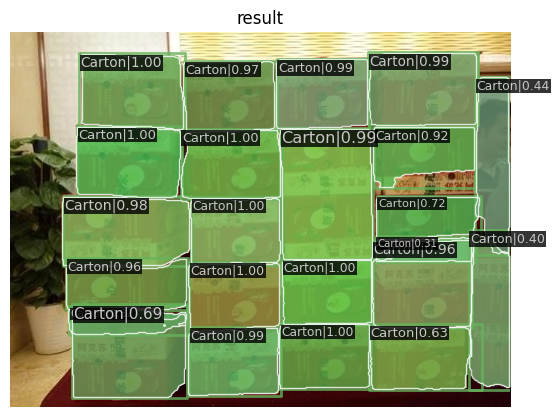

In [148]:
# show the results
show_result_pyplot(model, img, result)

In [202]:
score_threshold = 0.3
result_0 = np.array(result[0])# (1, 33, 5) -> 맨 처음 1 (클래스 갯수가 1이라서) / 33개 탐지 / [xmin, ymin, xmax, ymax, class confidence score]
result_1 = np.array(result[1])# <class 'numpy.ndarray'> (1, 33, 375, 500) -> 맨 처음 1 (클래스 갯수가 1이라서) / 33개 탐지 / [True, False masking image]

detections = result_0[0][np.where(result_0[0][:, 4] > score_threshold)]
segmentations = result_1[0][np.where(result_0[0][:, 4] > score_threshold)]

# Threshold로 Filtering된 결과물만 받기
np_detec = np.array(detections) #result[0]
np_segm = np.array(segmentations) # result[1]


In [203]:
np_segm = np.where(np_segm == 1, 255, np_segm)
print(np_segm.shape)
masks = np.array(np_segm).astype(np.uint8)


(23, 375, 500)


In [204]:
# Segmentation mask
# masks = [np.where(m == 1, 255, m) for m in result[1]]
# print(masks[0].shape)
# print(masks[0])
# masks = np.array(masks[0])
# masks = masks.astype(np.uint8)

In [205]:
def draw_polygon(target_img, polygon):
    
    target_img = cv2.polylines(target_img, polygon, True, (255,0,0), 1)
    # Cv2랑 PIL 억지로 바꿔서 RGB, BGR 차이 있음

    target_img = Image.fromarray(target_img)
    draw = ImageDraw.Draw(target_img)
    #str(label+":"+key_value)
    return_img = np.array(target_img)
    
    return return_img

True

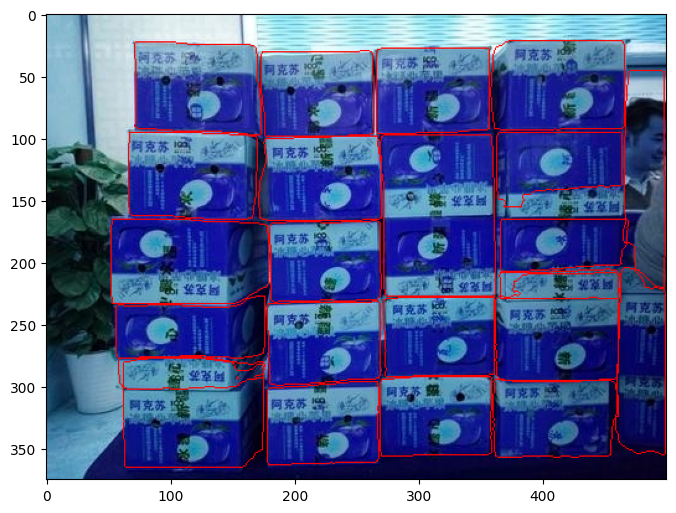

In [206]:
image = cv2.imread(img)
for i, mask in enumerate(masks):
    polygons = Mask(mask).polygons()
    image = draw_polygon(image, polygons.points)

result_img = image
plt.imshow(result_img)
cv2.imwrite("./result.jpg", result_img)